In [1]:
# PDF versions of the plots included in this file can get very large, use PNG to save space
options(jupyter.plot_mimetypes = 'image/png')

# MDI++ Demo in iPython/Jupyter #

This document demonstrates `mdi++` in an Jupyter notebook, it is therefore a "live" document with the intention that you can download and locally execute the included code.

## Generating Demo Datasets ##

We start by loading in some code that will allow us to regenerate our "demonstration" datasets:

In [2]:
source("../demo/datagen.R")

next we sample our cluster allocations (for 100 items) from a Dirichlet Process and generate one dataset for each datatype supported by MDI.  The default output formated used by R is compatible with MDI++ so we just write them directly out.

In [3]:
(base <- rdirichletprocess(100))

write.csv(create.normgam(base,        10),  "../demo/normgam.csv")
write.csv(create.gaussianprocess(base,20),  "../demo/gaussianprocess.csv")
write.csv(create.multinom(base, rep(3,10)), "../demo/multinom.csv")
write.csv(create.bagofwords(base,100, 10),  "../demo/bagwords.csv")

[1] 1 1 1 2 3 1 2 4 1 3 3 4 2 3 4 2 2 2 5 2 2 2 4 3 6 2 3 4 3 2 4 3 2 2 2 2 2
 [38] 4 4 3 4 2 4 3 2 4 2 4 4 2 2 2 4 2 2 2 4 4 3 2 4 2 4 3 2 2 3 4 3 2 3 3 4 4
 [75] 2 3 1 1 2 2 4 3 5 2 2 5 4 2 2 4 2 4 4 2 2 2 3 2 3 2

The second parameter in the above `create.*` scripts is generally the number of features, but for the Multinomial and Bag-of-Words datatypes things are more complicated—have a look inside `datagen.R` if you wish to see the details!

## Running MDI++ ##

Now that we have generated some datasets we can run `mdi++` on them, we `cd` into the relevant subdirectory and execute `mdi++` that you have hopefully just built.  Each dataset is preceeded by a flag specifying its datatype, `N` for Independent Normal/Gaussian features, `GP` for Gaussian Process, `M` for Multinomial and `BW` for Bag-of-Words. We use a standard shell redirection (i.e. the `> mcmc.csv`) to save results to disk.

In [4]:
system(paste("cd ../demo",
             "../mdi++ N normgam.csv GP gaussianprocess.csv M multinom.csv BW bagwords.csv > mcmc.csv",
             sep=";"))

All Monte-Carlo output will now be saved in the CSV file "`demo/mcmc.csv`" and is formatted such that it can be easily loaded using the standard R functions.  I have a variety of functions in `scripts/analysis.R` intended for interpreting this output.

## Analysing MDI++ Output ##

We start by pulling the analysis code into our workspace, installing the `mcclust` package if necessary.

In [5]:
if(!require("mcclust")) install.packages("mcclust")

source("../scripts/analysis.R")

Loading required package: mcclust
Loading required package: lpSolve


We can now load the data that was generated at the start into R enabling us to analyse the MCMC output.  The datasets generated were deliberately not retained within R so that this functionality can demonstrated, as it is assume that you will not be generating the data within R.

In [6]:
yg  <- loadDataGauss("../demo/normgam.csv")
ygp <- loadDataGP("../demo/gaussianprocess.csv")
ymn <- loadDataMultinom("../demo/multinom.csv")
ybw <- loadDataBagOfWords("../demo/bagwords.csv")

# Put the resulting dataframes into a list for easy access
datafiles <- list(yg,ygp,ymn,ybw)

We can start by ensuring that the data looks appropriate, thus demonstrating that `plot` as been overloaded.

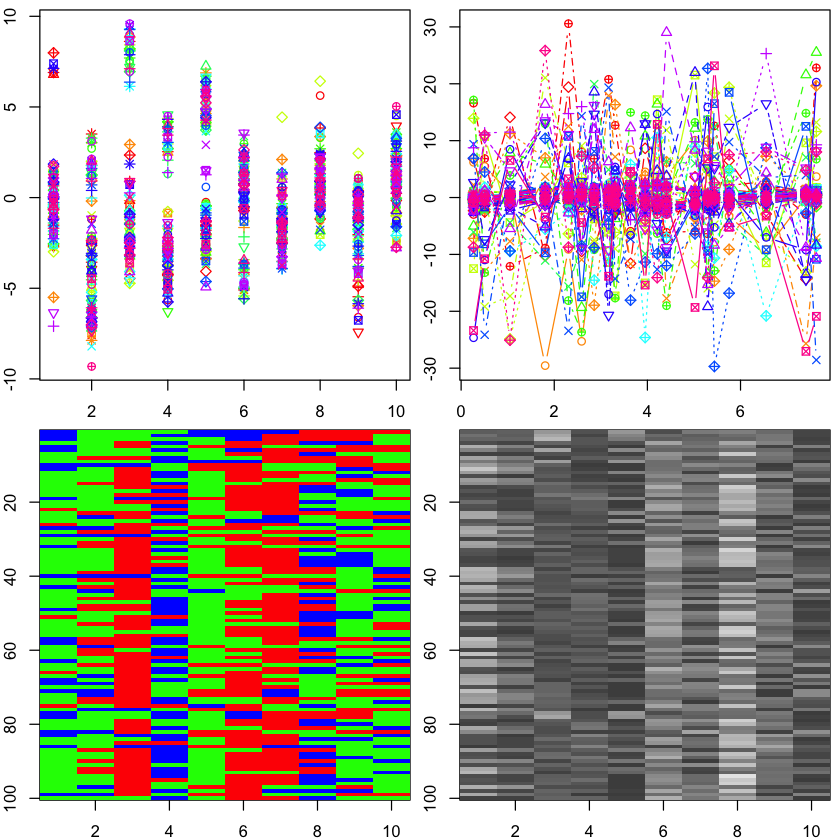

In [7]:
par(mfrow=c(2,2),mar=c(2,2,0.5,0.5))
for (y in datafiles) plot(y)

Next we load MDI's MCMC output into R:

In [8]:
mcmc <- readMdiMcmcOutput("../demo/mcmc.csv")

I would tend to but command into its own cell as loading a large file can take a significant amount of time.

Once it has loaded we can plot a sample from the posterior.  This plot has one row per dataset, with each columns being a single cluster.  Each plot will contain the items selected for that cluster and dataset, and can be empty if there are no items in that dataset's clustering.

If you're working on your own analysis I would recommend plotting a variety of samples to ensure that "similar" samples end up in the appropriate clusters and that these associations are shared across datasets.

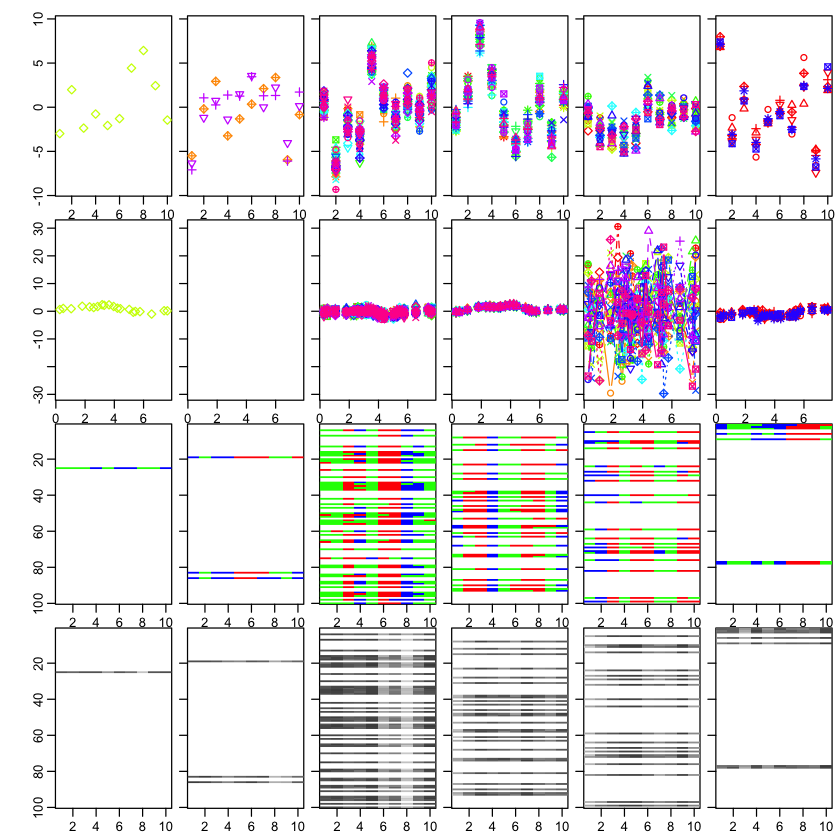

In [9]:
plotSingleMcmcSample(mcmc[5000,],datafiles)

Another plot that has been useful is the agreement in allocations between datasets—termed "fusion".  Plotting high dimensional data is difficult, so all plots for all pairwise combinations are generated.  Each individual plot describes the cumulative average agreement over the second half of the MCMC samples (i.e. first half is considered burn-in) after thining to 2000 samples.

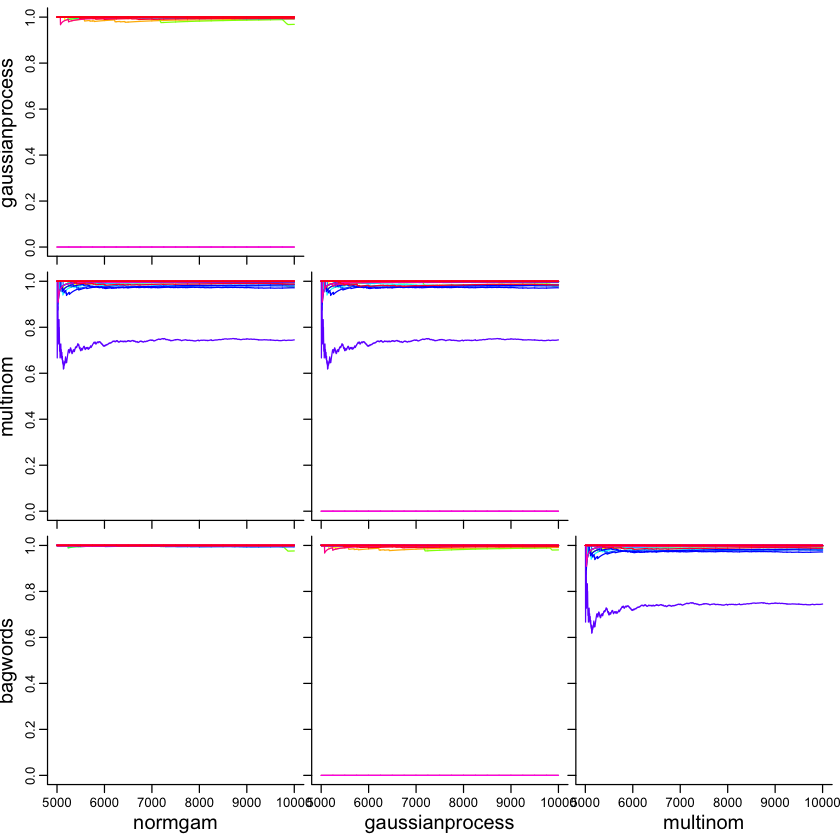

In [10]:
plotAllocationAgreement(tail(mcmc,2000))

In this case the chain appears to have converged, one is looking for MC uncertainty in early samples and no systematic drift in later samples.  Then it can be helpful to simplify to a marginal histograms.

In the plot below we show the posteriour mass associated with each number of allocation agreements across every pairwise combination of datasets, with the mean agreement indicated by the dotted vertical line.  In this case we know that every dataset has exactly the same cluster partition and so we see all 100 items basically agreeing and only limited uncertainty.  In real datasets we would expect much less consistency between datasets.

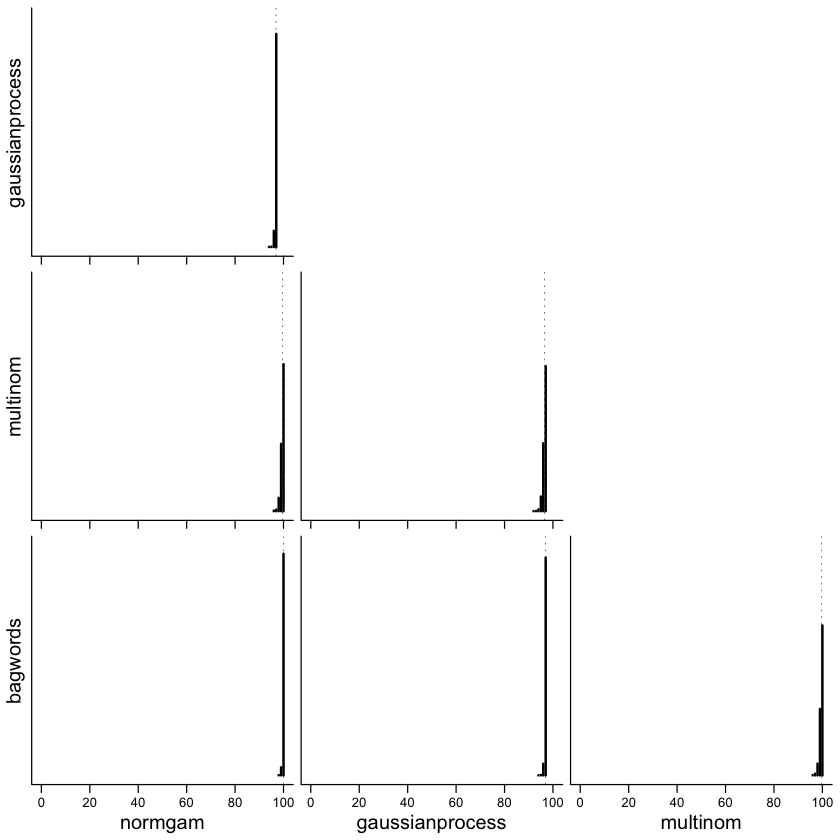

In [11]:
plotAllocationAgreementHistogram(tail(mcmc,2000),datafiles)

In a number of publications it has been found that a Posterior Similarity Matrix is a good way to describe the output of MDI, and other similar algorithms, that generate many posterior samples.  Code included in MDI makes it easy to generate a PSM and then perform plot the PSM with items ordered by a hierarchical clustering of the matrix.

We start by generating PSMs across each dataset independently and them sum to get an average/consensus PSM.

In [12]:
cpsm <- generateConsensusPSM(tail(mcmc))

In order to generate a plot, we need to take a guess at the number of clusters at which to "cut" the hierarchical clustering—here we use the median across all datasets.

We can then plot the PSMs for each dataset independently along with the consensus.

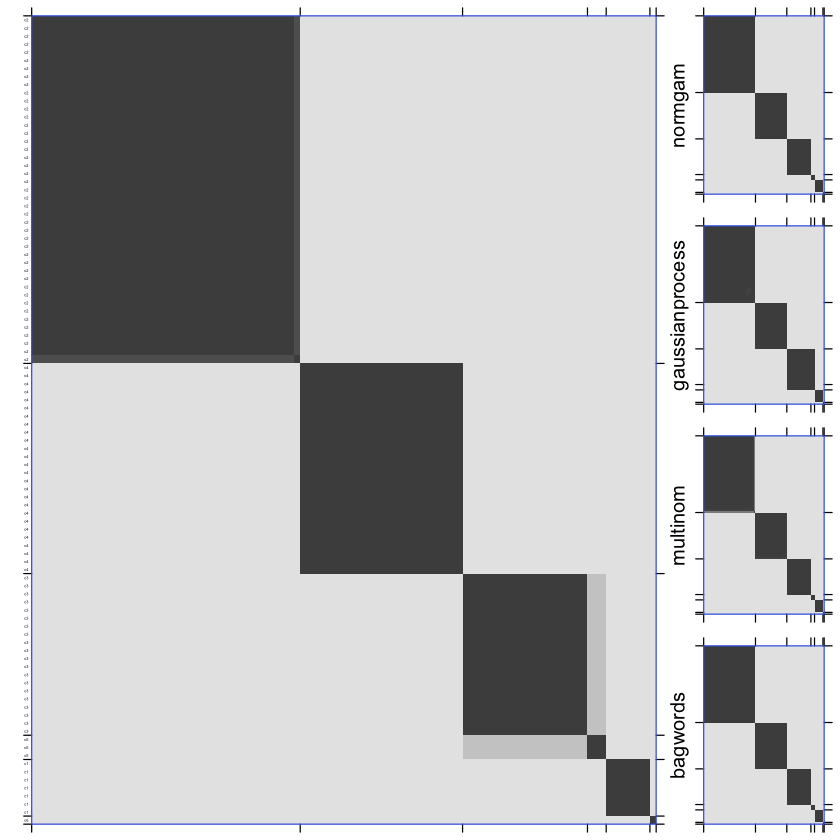

In [13]:
nclust <- apply(getClustersOccupied(tail(mcmc,101)),2,median)

par(mar=c(1,2,1,1)); plotConsensusPSM(cpsm, datafiles, median(nclust), ann = TRUE)

Darker colors indicate greater agreement and the black ticks on the axes display the inferred cluster partition across the consensus PSM.  As can be seen there is little uncertainty in the cluster allocations given this data.

Further analysis/plotting tends to be application specific and depends on the degree of fusion between datasets.  For example each datasets may utilise a different lab method and one may be interested highlighting the pairwise similarity between datasets, at which point the histogram of pairwise agreements may be enough.

Otherwise extracting the cluster allocation inferred for each data file may serve as useful input for further work.

In [14]:
head(cp <- extractPSMClustPartition(cpsm, nclust, datafiles))
write.csv(cp, "../demo/cluster-partition.csv")

,normgam,gaussianprocess,multinom,bagwords
c1,1,1,1,1
c1,1,1,1,1
c1,1,1,1,1
c2,2,2,2,2
c3,3,3,3,3
c1,1,1,1,1
